<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import re 
import spacy
from tqdm.notebook import tqdm
import warnings

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [3]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.sample(5)

,text,toxic
26152,"Per Wikipedia:Record charts, single-vendor cha...",0
66985,""" all full of presumption and you are also wro...",0
75618,Idk who you are and wtf you think you are runn...,1
63281,Goal Count\n\nI don't understand people that d...,1
90977,""" 2015 (UTC)\nDear , even though I did not rev...",0


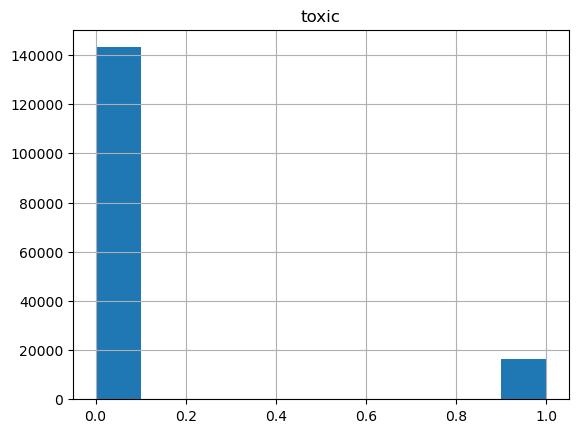

In [8]:
df.hist();

Интересно, не токсичных комментарии в разы больше

In [9]:
df.isna().sum()

text     0
toxic    0
dtype: int64

<b>Микровывод:</b> ничего выбивающегося нет, видно, что кол-во положительных отзывов гораздо больше, чем отрицательных

Начнем с лемматизации:

In [10]:
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

def clear_text(text): 
    doc = nlp(text)
    doc = ' '.join([token.lemma_ for token in doc])
    clean_text = re.sub(r'[^a-zA-z]', ' ', doc)
    clean_text = ' '.join(clean_text.split())
    return clean_text

df['clean_text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
df.head()

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разобьем на выборки:

In [12]:
features = df['clean_text']
target = df['toxic']

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                         test_size = 0.2,
                                                                         random_state = 12345,
                                                                         shuffle = True)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(127433,)
(127433,)
(31859,)
(31859,)


Учитываем стоп-слова:

In [14]:
count_tf_idf = TfidfVectorizer(stop_words='english')

In [15]:
train_tf_idf = count_tf_idf.fit_transform(features_train)
test_tf_idf = count_tf_idf.transform(features_test)

print(train_tf_idf.shape)
print(test_tf_idf.shape)

(127433, 140463)
(31859, 140463)


## Обучение

In [16]:
warnings.filterwarnings("ignore")

В качестве моделей возьмем: CatBoost, LightGBM и линейную регрессию.

<b>CatBoost</b>

In [17]:
model_cat = CatBoostClassifier()
parametrs = {'iterations': [90], 'depth': [5], 'random_state' : [12345]}
grid_cat = GridSearchCV(model_cat, parametrs, scoring = 'f1')
grid_cat.fit(train_tf_idf, target_train)
best_cat_f1 = grid_cat.best_score_
print(best_cat_f1)

Learning rate set to 0.5
0:	learn: 0.3537937	total: 901ms	remaining: 1m 20s
1:	learn: 0.2668686	total: 1.52s	remaining: 1m 7s
2:	learn: 0.2382951	total: 2.2s	remaining: 1m 3s
3:	learn: 0.2257235	total: 2.82s	remaining: 1m
4:	learn: 0.2140474	total: 3.46s	remaining: 58.8s
5:	learn: 0.2073772	total: 4.08s	remaining: 57.1s
6:	learn: 0.2002595	total: 4.69s	remaining: 55.7s
7:	learn: 0.1965785	total: 5.31s	remaining: 54.4s
8:	learn: 0.1921090	total: 5.93s	remaining: 53.4s
9:	learn: 0.1892577	total: 6.54s	remaining: 52.4s
10:	learn: 0.1860500	total: 7.23s	remaining: 51.9s
11:	learn: 0.1832370	total: 7.85s	remaining: 51s
12:	learn: 0.1812149	total: 8.47s	remaining: 50.2s
13:	learn: 0.1788587	total: 9.08s	remaining: 49.3s
14:	learn: 0.1759884	total: 9.71s	remaining: 48.5s
15:	learn: 0.1738133	total: 10.3s	remaining: 47.7s
16:	learn: 0.1720679	total: 10.9s	remaining: 46.9s
17:	learn: 0.1706033	total: 11.5s	remaining: 46.2s
18:	learn: 0.1685213	total: 12.3s	remaining: 46s
19:	learn: 0.1672770	to

In [18]:
print("Показатель f1:", best_cat_f1)

Показатель f1: 0.730863258706995


<b>LGBM</b>

In [19]:
LGBM = LGBMClassifier()
parametrs = [{'num_iterations': [90], 
    'max_depth': [4, 10], 
    'random_state' : [12345],}]

grid_LGBM = GridSearchCV(LGBM, parametrs, scoring = 'f1')
grid_LGBM.fit(train_tf_idf, target_train)
best_LGBM_f1 = grid_LGBM.best_score_
parametrs_LGBM = grid_LGBM.best_params_
print('Лучший параметр f1:', best_LGBM_f1)
print('Лучшие параметры:', parametrs_LGBM) 

Лучший параметр f1: 0.6848686964754498
Лучшие параметры: {'max_depth': 10, 'num_iterations': 90, 'random_state': 12345}


<b>Логистическая регрессия</b>

In [20]:
model_linear = LogisticRegression(random_state = 12345, class_weight = 'balanced') 
parametrs_lr = {'max_iter': [100]}
grid_lr = GridSearchCV(model_linear, parametrs_lr, scoring = 'f1')
grid_lr.fit(train_tf_idf, target_train)
best_lr_f1 = grid_lr.best_score_
print(best_lr_f1)

0.7531368107547294


<b>Микровывод: </b>из всех моделей наиболее хороший показатель F1 получился на логистической регрессии. Для итогового тестирования будем использовать ее.

In [21]:
predicted_lr = grid_lr.predict(test_tf_idf)
f1_lr_f1 = f1_score(target_test, predicted_lr)
f1_lr_f1

0.7540186410914494

## Выводы

Данные были загружены и изучены, предобработка не понадобилась. 

Далее было произведено: лемматизация (процесс приведения словоформы к лемме — её нормальной (словарной) форме), разбиение данных на выборки и работа со стоп-словами (для очищения от словарного "шума") для английского языка.

После подготовки были обучены три модели: _CatBoost_, _LightGBM_ и _LogisticRegression_. Самый большой показатель f1 (среднее значение Accuracy и Отзыва Recall) показала логистическая регрессия, он был равен _0,753_, поэтому итоговое тестирование было произведено на этой модели.

Итоговый результат на модели логистической регресси = _0,754_. Данный результат нам подходит, значит дальнейшая работа не требуется.